In [11]:
#IMPORT ALL LIBRARIES

from sklearn.datasets import make_blobs
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
import pandas as pd 
import numpy as np

from rerf.urerf import UnsupervisedRandomForest
from sklearn.manifold import MDS

In [12]:
#Creating a synthetic data set using the make_blobs function
#No. of samples = 500
#No. of features = 2

Input_data = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=1.1, 
                   center_box=(-5.0, 5.0), shuffle=False, random_state=1)
X = Input_data[0] #input data points
Y = Input_data[1] #Labels associated with the data

X.shape

(500, 2)

In [21]:
#Center the data and make a pandas data frame of the input data

X_scaled = X - X.mean() #this centers the data

data_frame = pd.DataFrame(X_scaled,columns=['x'+str(i) for i in range(1,3)])
data_frame['y'] = Y


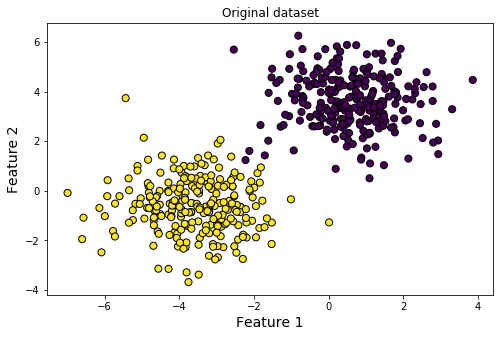

In [22]:
#Scatter plot for the original data 
plt.figure(figsize=(8,5))    
plt.scatter(data_frame['x1'],data_frame['x2'],s=50,c=data_frame['y'], edgecolors='black')

plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.title("Original dataset")
plt.show()

In [23]:
#Define the USPORF model
clf = UnsupervisedRandomForest(projection_matrix="RerF", random_state=0)

In [24]:
#Fit this model to the input data 
clf.fit(X_scaled)

UnsupervisedRandomForest(feature_combinations='auto', max_depth=None,
                         max_features='auto', min_samples_split='auto',
                         n_estimators=100, n_jobs=None,
                         projection_matrix='RerF', random_state=0)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


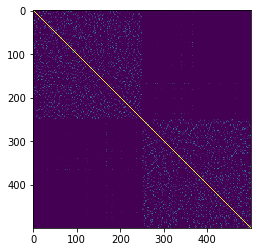

In [25]:
#Store the ouput of USPORF which is a similarity matrix and plot 
sim_mat = clf.transform()
print(sim_mat)
plt.imshow(sim_mat)

In [26]:
#According to the previous run experiments, we found that the similarity matrix isn't truely symmetric 
#Utilize the grapsy function to make it symmetric 
def symmetrize(graph, method="avg"):

    if method == "triu":
        graph = np.triu(graph)
    elif method == "tril":
        graph = np.tril(graph)
    elif method == "avg":
        graph = (np.triu(graph) + np.tril(graph)) / 2
    else:
        msg = "You have not passed a valid parameter for the method."
        raise ValueError(msg)
    # A = A + A' - diag(A)
    graph = graph + graph.T - np.diag(np.diag(graph))
    return graph

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


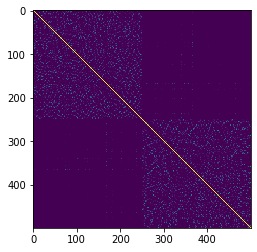

In [27]:
#New similarity matrix after making it symmetric
new_sim = symmetrize(sim_mat)
print(new_sim)
plt.imshow(new_sim)

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


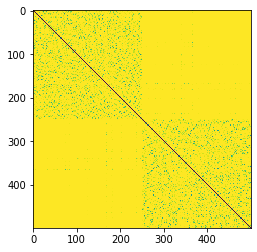

In [28]:
#Create a dissimilarity matrix by 1-new_sim
diss_mat = 1 - new_sim
print(diss_mat)
plt.imshow(diss_mat)

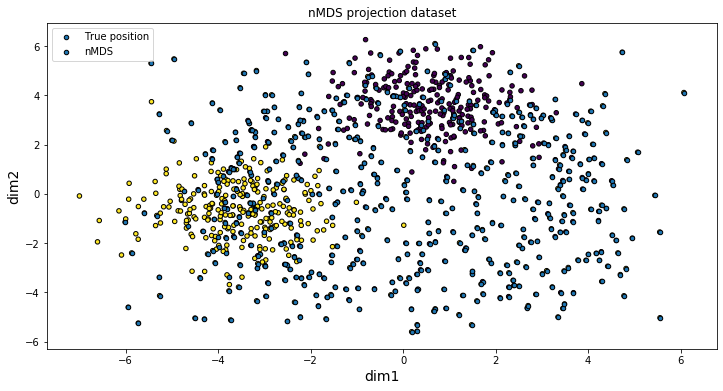

In [33]:
model = MDS(n_components=2, metric = False, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(diss_mat)
plt.figure(figsize=(12,6))
out *= np.sqrt((X_scaled** 2).sum()) / np.sqrt((out ** 2).sum()) #as per sklearn's example, not sure what this is doing really
plt.scatter(out[:, 0], out[:, 1],s = 20, c=data_frame['y'], edgecolors='black')
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s = 20, c=data_frame['y'], edgecolors='black')
plt.scatter(out[:, 0], out[:, 1], s= 20, cmap=plt.cm.get_cmap('jet', 10),edgecolors='black')
plt.legend(('True position','nMDS'), loc='best')
plt.xlabel('dim1',fontsize=14)
plt.ylabel('dim2',fontsize=14)
plt.title("nMDS projection dataset")
plt.show()

In [34]:
#EXPERIMENTAL SECTION
#I took the MDS projection points and tried to contruct a distance matrix(Euclidean) -> found a few resources online to do this
# The data won't be in Euclidean space but i'm not sure what else to do to perform agglomerative clustering on the 
#output of MDS 
from scipy.spatial import distance_matrix

# Original code from OP, slightly reformatted
sample_df1 = pd.DataFrame(out,columns=['x'+str(i) for i in range(1,3)])

# Whole similarity algorithm in one line
df_euclid =(1 / (1 + distance_matrix(sample_df1, sample_df1)))

In [36]:
df_euclid

array([[1.        , 0.190636  , 0.1709777 , ..., 0.18415836, 0.35578857,
        0.30240915],
       [0.190636  , 1.        , 0.32895801, ..., 0.10593057, 0.22104397,
        0.16969998],
       [0.1709777 , 0.32895801, 1.        , ..., 0.09730032, 0.17074264,
        0.13829384],
       ...,
       [0.18415836, 0.10593057, 0.09730032, ..., 1.        , 0.16588165,
        0.2041711 ],
       [0.35578857, 0.22104397, 0.17074264, ..., 0.16588165, 1.        ,
        0.41844591],
       [0.30240915, 0.16969998, 0.13829384, ..., 0.2041711 , 0.41844591,
        1.        ]])

In [35]:
from scipy.spatial.distance import pdist,squareform
sample_df = pd.DataFrame(out,columns=['x'+str(i) for i in range(1,3)])
#sample_df.head()
p_dist = squareform(pdist(sample_df, metric='euclidean'))
#print(p_dist)
sim = 1 - p_dist
print(sim)

[[ 1.         -3.24559884 -3.84871602 ... -3.43010926 -0.81065801
  -1.30677823]
 [-3.24559884  1.         -1.03990168 ... -7.44014522 -2.5239867
  -3.89275254]
 [-3.84871602 -1.03990168  1.         ... -8.27745865 -3.85676773
  -5.23097983]
 ...
 [-3.43010926 -7.44014522 -8.27745865 ...  1.         -4.02839436
  -2.89785291]
 [-0.81065801 -2.5239867  -3.85676773 ... -4.02839436  1.
  -0.38979516]
 [-1.30677823 -3.89275254 -5.23097983 ... -2.89785291 -0.38979516
   1.        ]]


In [37]:
#I previously checked if these are symmetric and they are

In [45]:
cluster2 = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="average")
predict_labels2 = cluster2.fit_predict(df_euclid)
score2 = adjusted_rand_score(Y, predict_labels2)

print("labels\n", Y)
print("predict\n", predict_labels2)
print("Adjusted Rand Score:", score2)

labels
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 

In [46]:
cluster3 = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="average")
predict_labels3 = cluster3.fit_predict(sim)
score3 = adjusted_rand_score(Y, predict_labels3)

print("labels\n", Y)
print("predict\n", predict_labels3)
print("Adjusted Rand Score:", score3)

labels
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 

In [ ]:
#Both of these give an ARS of 0